# Interconnect: Anticipando la Fuga con Machine Learning

🌐 Panorama

En Interconnect, cada cliente que se va representa más que una baja en las cifras: es una relación de pérdida. Detectar a tiempo cuándo un usuario está por cancelar su servicio puede marcar la diferencia entre retenerlo o dejarlo ir.

Por eso, el equipo de marketing ha reunido datos clave sobre nuestros clientes: desde información personal y hábitos de consumo, hasta detalles de sus planes y contratos.

🎯 Objetivo

Construir un modelo de machine learning capaz de predecir, con la mayor precisión posible, qué clientes tienen mayor probabilidad de cancelar su servicio. Con esta herramienta, Interconnect podrá tomar decisiones más inteligentes y rápidas, ofreciendo promociones personalizadas o planes especiales que fortalezcan la relación con el cliente y reduzcan la tasa de cancelación.

# 0. Cargar bibliotecas

In [1]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from scipy.stats import levene, ttest_ind
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance


In [2]:
import xgboost as xgb
print(xgb.__version__)

3.0.2


In [3]:
import os
print(os.getcwd())

/Users/grafico/Downloads/Data/Project_DS/VC/final_provider


## 1. Exploración Inicial

In [4]:
df_contract = pd.read_csv('contract.csv')

df_internet = pd.read_csv('internet.csv')

df_personal = pd.read_csv('personal.csv')

df_phone = pd.read_csv('phone.csv')

In [5]:
print("Contract:")
print(df_contract.dtypes)
print("\n Internet:")
print(df_internet.dtypes)
print("\n Personal:")
print(df_personal.dtypes)
print("\n Phone:")
print(df_phone.dtypes)

Contract:
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

 Internet:
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

 Personal:
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

 Phone:
customerID       object
MultipleLines    object
dtype: object


In [6]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


#### Estado General de los Datos

Tras revisar los dataframes df_contract, df_internet, df_personal y df_phone, se identifican algunos puntos clave:

'MonthlyCharges' ya está en formato numérico y listo para análisis.

'TotalCharges' en cambio, sigue como tipo object, lo que sugiere que hay valores no válidos (vacíos o con símbolos) que impidieron su conversión. Hay que depurarlo bien antes de usarlo.

Columnas como BeginDate, EndDate, Type, PaperlessBilling, etc., están como object, por lo que se debe convertir fechas al tipo datetime y las demás variables categóricas a formato numérico.

En df_internet, df_personal y df_phone, casi todas las variables son también categóricas (object), por lo que será necesario aplicar codificación (como One-Hot o Label Encoding) para que puedan ser utilizadas en modelos de ML.

Con los datos consolidados antes de modelar es clave:

Convertir correctamente 'TotalCharges' a número.

Codificar las variables categóricas en todos los dataframes.

In [10]:
# Quitar espacios y poner en minúscula todos los nombres de columnas
for df in [df_contract, df_internet, df_phone, df_personal]:
    df.columns = df.columns.str.strip().str.lower()

# Renombrar customerid si es necesario
for df in [df_contract, df_internet, df_phone, df_personal]:
    if 'customerid' in df.columns:
        df.rename(columns={'customerid': 'customerID'}, inplace=True)

In [11]:
def clean_totalcharges(val):
    """
    Limpia y convierte a float una cadena de TotalCharges.
    - Elimina todo salvo dígitos y puntos.
    - Conservar solo el último punto como separador decimal.
    """
    if pd.isna(val):
        return np.nan

    val = ''.join(ch for ch in str(val) if ch.isdigit() or ch == '.')

    # si hay más de un punto, tomar el último como decimal
    if val.count('.') > 1:
        *int_part, dec_part = val.split('.')
        val = ''.join(int_part) + '.' + dec_part 

    try:
        return float(val)
    except ValueError:
        return np.nan

# Aplicar a la columna
df_contract['totalcharges'] = df_contract['totalcharges'].apply(clean_totalcharges)

# Imputar NaN con la media
df_contract['totalcharges'] = df_contract['totalcharges'].fillna(df_contract['totalcharges'].mean())

print(df_contract['totalcharges'].head())

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: float64


Estos resultados confirman que la columna 'totalcharges' (que antes nos daba problemas) ahora está en el formato numérico correcto (float64), lo que permite realizar cálculos y utilizarla en modelos de Machine Learning sin inconvenientes de tipo de dato. Has resuelto el problema de la conversión de esta columna.

In [12]:
binary_cols = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
for col in binary_cols:
    if col in df_internet.columns:
        df_internet[col] = df_internet[col].apply(lambda x: 1 if x == 'Yes' else 0)

In [13]:
# Crear la variable Objetivo 'Churn'
df_contract['churn'] = df_contract['enddate'].apply(lambda x: 0 if x == 'No' else 1)
df_contract['churn'] = df_contract['churn'].astype(int)

In [14]:
# Unificar todos los DataFrames correctamente
df_full = df_contract.merge(df_internet, on='customerID', how='left')
df_full = df_full.merge(df_phone, on='customerID', how='left')
df_full = df_full.merge(df_personal, on='customerID', how='left')

 ## 2. Análisis Exploratorio de los datos

In [15]:
df_contract['monthlycharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthlycharges, dtype: float64

Hay una alta variabilidad en los cargos mensuales.

La distribución parece estar sesgada a la izquierda, ya que la media ($64.76) es menor que la mediana ($70.35).

Hay una parte de clientes con cargos muy bajos (< $35) y otros con cargos altos (> $90).

In [16]:
df_contract['totalcharges'].describe()

count    7043.000000
mean     2283.300441
std      2265.000258
min        18.800000
25%       402.225000
50%      1400.550000
75%      3786.600000
max      8684.800000
Name: totalcharges, dtype: float64

Hay una distribución amplia, lo que refleja que los clientes tienen duraciones y niveles de servicio muy distintos.

La diferencia entre el mínimo ($18.80) y el máximo ($8,684.80) sugiere que algunos clientes llevan años y otros apenas días/meses.

'totalcharges' es una variable clave, ya que captura el historial económico del cliente.

### Distribución de clases

In [17]:
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'], errors='coerce')

# Identificar la fecha más reciente
last_date = df_contract['enddate'].max()

# Crear la variable 
df_contract['churn'] = (df_contract['enddate'] != last_date).astype(int)

print("Distribución de clases (churn):")
print(df_contract['churn'].value_counts(normalize=True).map("{:.2%}".format))

Distribución de clases (churn):
churn
1    93.47%
0     6.53%
Name: proportion, dtype: object


/var/folders/zl/w794_z6n5ql7jj9vmgcp8zqc0000gn/T/ipykernel_34322/976303166.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract['enddate'] = pd.to_datetime(df_contract['enddate'], errors='coerce')


Distribución de clases:

Hay muchos más casos de churn (cancelación) que de no churn.

El modelo puede aprender a predecir siempre 1 (churn) y aún así tener una alta exactitud (accuracy), pero estaría fallando en detectar correctamente a los clientes que se quedan.

Este tipo de desbalance afecta negativamente el rendimiento del modelo, especialmente en métricas como precision, recall y F1-score.

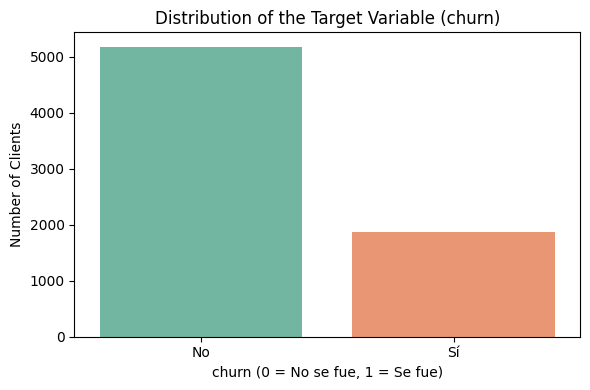

In [18]:
# Gráfico de barras
plt.figure(figsize=(6,4))
sns.countplot(x='churn', hue='churn', data=df_full, palette='Set2', legend=False)

plt.title('Distribution of the Target Variable (churn)')
plt.xlabel('churn (0 = No se fue, 1 = Se fue)')
plt.ylabel('Number of Clients')
plt.xticks([0,1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

Interpretación de los datos:

Hay más clientes que no se fueron (aproximadamente 5100).

Hay menos clientes que se fueron (alrededor de 1900).

Esto significa que en la base de datos, la mayoría de los clientes siguen usando el servicio, pero hay una proporción significativa que sí se dio de baja.

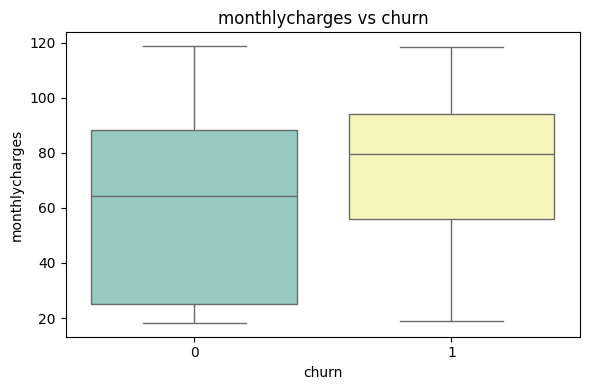

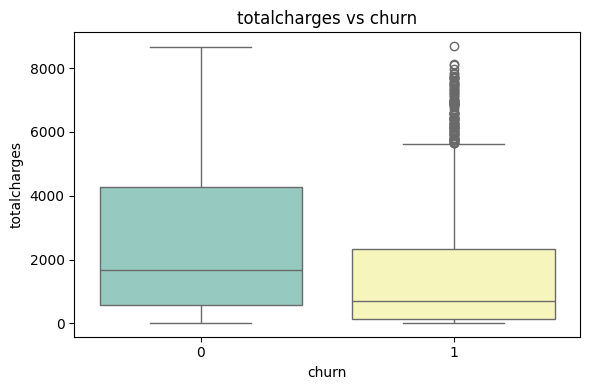

In [19]:
cols_interes = ['monthlycharges', 'totalcharges']

for col in cols_interes:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='churn', y=col, data=df_full, hue='churn', palette='Set3', legend=False)
    plt.title(f'{col} vs churn')
    plt.tight_layout()
    plt.show()

El análisis sugiere que los clientes que han permanecido en el servicio tienden a haber acumulado un mayor monto total pagado, lo cual es coherente con una relación más larga y estable con la empresa. Por otro lado, quienes se dan de baja suelen tener un historial de pagos totales mucho menor, lo que indica que se fueron en etapas tempranas del servicio.

Un hallazgo clave es que muchos de estos clientes que se van temprano presentan cargos mensuales elevados, lo que sugiere un posible desajuste entre el precio pagado y el valor percibido. Es decir, son clientes nuevos que invierten más desde el inicio, pero no encuentran suficientes beneficios como para justificar el costo, por lo que abandonan rápidamente.

Esto abre una oportunidad estratégica: ofrecer planes de entrada más asequibles, escalonados o personalizados, que permitan al nuevo cliente conocer el servicio gradualmente y generar una percepción de valor antes de comprometerse con pagos más altos. Esta medida podría contribuir significativamente a reducir la tasa de cancelación temprana.

## 3. Preprocesamiento

In [20]:
# Convertir fechas
df_contract['begindate'] = pd.to_datetime(df_contract['begindate'])
df_contract['enddate'] = df_contract['enddate'].replace('No', pd.Timestamp.today())
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'])

In [21]:
# Crear variable Tenure (antigüedad en meses)
df_contract['tenure'] = (df_contract['enddate'] - df_contract['begindate']).dt.days // 30

In [22]:
# Convertir totalcharges a numérico
df_contract['totalcharges'] = df_contract['totalcharges'].fillna(df_contract['totalcharges'].mean())
df_contract['totalcharges'] = pd.to_numeric(df_contract['totalcharges'], errors='coerce')

## 4. Separación

In [23]:
X = df_full.drop(columns=['churn', 'customerID'])
y = df_full['churn']

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Codificar Variables Categóricas

In [24]:
# Codificar variables categóricas sin eliminar columnas clave
df_contract = pd.get_dummies(df_contract, columns=['type', 'paperlessbilling', 'paymentmethod'], drop_first=True)
# One-hot de internetservice
df_internet = pd.get_dummies(df_internet, columns=['internetservice'], drop_first=True)

In [25]:
if 'multiplelines' in df_phone.columns:
    df_phone['multiplelines'] = df_phone['multiplelines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [26]:
# Aplicar one-hot encoding solo a columnas categóricas
df_personal = pd.get_dummies(df_personal, columns=['gender', 'partner', 'dependents'], drop_first=True)

In [27]:
cat_cols = df_full.select_dtypes(include=['object', 'category']).columns.tolist()
print("Variables categóricas:", cat_cols)

Variables categóricas: ['customerID', 'begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'multiplelines', 'gender', 'partner', 'dependents']


In [28]:
df_full_encoded = pd.get_dummies(df_full, columns=cat_cols, drop_first=True)
print(df_full_encoded.shape)
print(df_full_encoded.head())

(7043, 7143)
   monthlycharges  totalcharges  churn  onlinesecurity  onlinebackup  \
0           29.85         29.85      0             0.0           1.0   
1           56.95       1889.50      0             1.0           0.0   
2           53.85        108.15      1             1.0           1.0   
3           42.30       1840.75      0             1.0           0.0   
4           70.70        151.65      1             0.0           0.0   

   deviceprotection  techsupport  streamingtv  streamingmovies  seniorcitizen  \
0               0.0          0.0          0.0              0.0              0   
1               1.0          0.0          0.0              0.0              0   
2               0.0          0.0          0.0              0.0              0   
3               1.0          1.0          0.0              0.0              0   
4               0.0          0.0          0.0              0.0              0   

   ...  type_Two year  paperlessbilling_Yes  \
0  ...          Fals

El conjunto de datos ha sido transformado correctamente para su uso en modelos predictivos, convirtiendo las variables categóricas en columnas numéricas mediante codificación one-hot.
Esto permite trabajar con algoritmos de machine learning sin perder información valiosa.

La variable objetivo sigue siendo churn, que indica si un cliente se fue (1) o permaneció (0) en el servicio.
Además, se incluyen datos sobre servicios contratados como seguridad en línea, soporte técnico o televisión en streaming, que permiten identificar patrones de uso y posibles factores asociados a la cancelación.

También están presentes variables numéricas clave como monthlycharges (cargo mensual) y totalcharges (total pagado), fundamentales para analizar el comportamiento económico de los clientes.
Como se ha observado antes, aquellos con pagos mensuales altos pero bajo total acumulado podrían estar en mayor riesgo de abandono.

Por último, se incluyen factores adicionales como el tipo de facturación o el método de pago, que podrían influir en la decisión de cancelación y aportar valor al modelo predictivo.

### Escalar variables numéricas 

In [29]:
scaler = StandardScaler()
for col in ['monthlycharges', 'totalcharges', 'tenure']:
    if col in df_full.columns:
        df_full[col] = scaler.fit_transform(df_full[[col]])

print("Dataset final listo con shape:", df_full.shape)
print(df_full.head())

Dataset final listo con shape: (7043, 21)
   customerID   begindate              enddate            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperlessbilling              paymentmethod  monthlycharges  totalcharges  \
0              Yes           Electronic check       -1.160323     -0.994971   
1               No               Mailed check       -0.259629     -0.173876   
2              Yes               Mailed check       -0.362660     -0.960399   
3               No  Bank transfer (automatic)       -0.746535     -0.195400   
4              Yes           Electronic check        0.197365     -0.941193   

   churn internetservice  ...  onlinebackup  deviceprotection  techsupport  \
0      0

El conjunto de datos ya se encuentra completamente preparado para el análisis y modelado predictivo. Se han escalado correctamente las variables numéricas clave —monthlycharges, totalcharges y tenure— utilizando un estándar de normalización, lo que garantiza que todas estén en la misma escala. Esto es especialmente importante para modelos que son sensibles a la magnitud de los datos, como los que se basan en distancias o pesos numéricos.

Además, el dataset conserva tanto variables relacionadas con el comportamiento del cliente (como el tipo de contrato, método de pago o servicios contratados), como características demográficas. Esta combinación de datos permite tener una visión integral del perfil del cliente y genera una base sólida para entrenar modelos que predigan con precisión la probabilidad de abandono.

Con un total de 7.043 registros y 21 variables, el conjunto está listo para avanzar hacia el análisis exploratorio o la construcción de modelos predictivos.

## 5. Pipeline de preprocesamiento

In [30]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),      
    ('scaler', StandardScaler())                       
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')) 
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [31]:
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ]), cat_cols)
])

In [32]:
pipeline_smote_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

## 6. Definición de modelos

In [33]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=10)
}

pipelines = {
    name: ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    for name, model in models.items()
}

In [34]:
pipelines = {
    name: ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    for name, model in models.items()
}

## 7. Entrenamiento y evaluación

In [35]:
results = {}

for name, pipeline in pipelines.items():
    print(f"\n🔹 Train & Test Model: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]

    # Métricas
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    roc_auc   = roc_auc_score(y_test, y_proba)

    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {roc_auc:.3f}")
    
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }

results_df = pd.DataFrame(results).T.sort_values(by='F1-score', ascending=False)

print("\n Comparation models (F1-score):")
display(results_df.style.background_gradient(cmap='Greens'))


🔹 Train & Test Model: LogisticRegression
Precision: 0.495
Recall:    0.695
F1-score:  0.578
ROC-AUC:   0.811

🔹 Train & Test Model: DecisionTree
Precision: 0.452
Recall:    0.588
F1-score:  0.511
ROC-AUC:   0.671

🔹 Train & Test Model: RandomForest
Precision: 0.507
Recall:    0.594
F1-score:  0.547
ROC-AUC:   0.787

🔹 Train & Test Model: KNN
Precision: 0.479
Recall:    0.687
F1-score:  0.565
ROC-AUC:   0.779

 Comparation models (F1-score):


,Precision,Recall,F1-score,ROC-AUC
LogisticRegression,0.495238,0.695187,0.578420,0.810907
KNN,0.479478,0.687166,0.564835,0.778628
RandomForest,0.506849,0.593583,0.546798,0.786676
DecisionTree,0.451745,0.588235,0.511034,0.670559


### Comparación del desempeño de los cuatro modelos entrenados
—Logistic Regression, Decision Tree, Random Forest, and KNN— observé diferencias importantes en cuanto a precisión, recall, F1-score y ROC-AUC.

El modelo Logistic Regression, se destaca como el más equilibrado, obteniendo el mejor F1-score (0.578) y también el mayor valor de ROC-AUC (0.81), lo cual es indicador d una buena capacidad para distinguir entre clientes que se quedan y los que se van. Además, mantiene un buen balance entre precisión (0.49) y recall (0.69), lo que lo hace confiable en contextos donde ambos aspectos importan.

El modelo KNN también muestra un rendimiento aceptable, con un F1-score cercano (0.565) y un buen nivel de recall (0.68), lo que sugiere que identifica correctamente una alta proporción de los clientes que se dan de baja, aunque con una ligera pérdida de precisión.

Random Forest, si bien no supera a los anteriores en F1-score, logra la mejor precisión (0.50), lo que puede ser útil si se desea minimizar falsos positivos. Sin embargo, su capacidad general para equilibrar todas las métricas es más baja.

Finalmente, Decision Tree es el modelo con menor rendimiento en todos los indicadores, lo cual lo descarta como opción óptima para este caso.

### Visualización Curva + Confusion Matrix


🔸Visualization for model: LogisticRegression


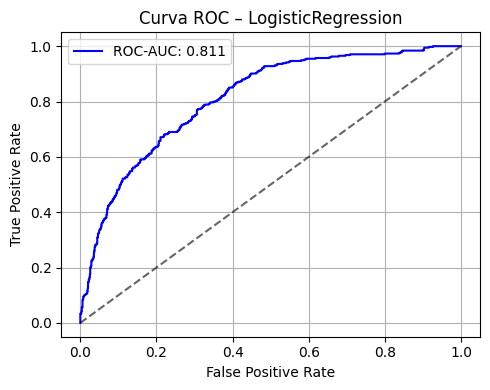

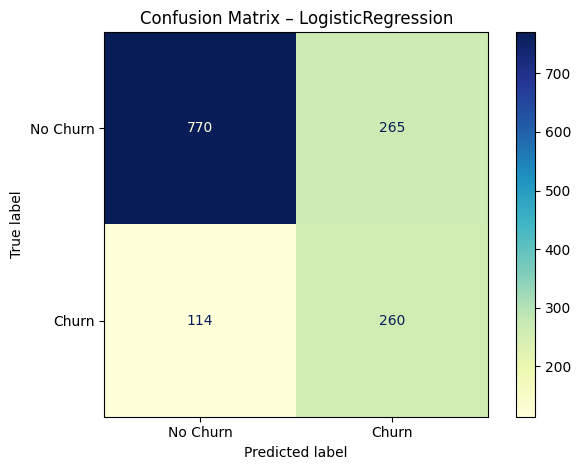


🔸Visualization for model: DecisionTree


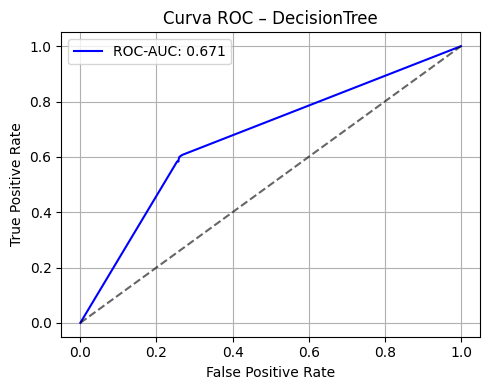

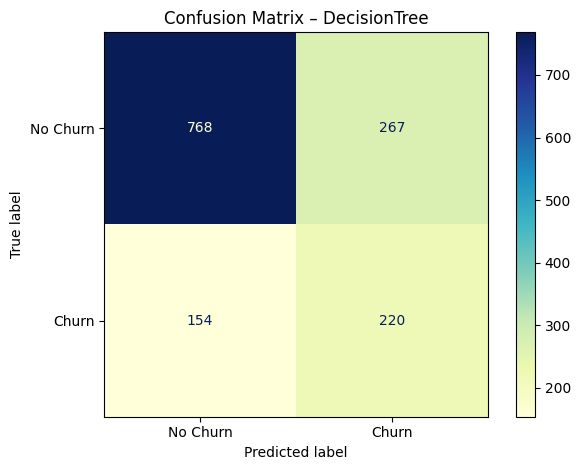


🔸Visualization for model: RandomForest


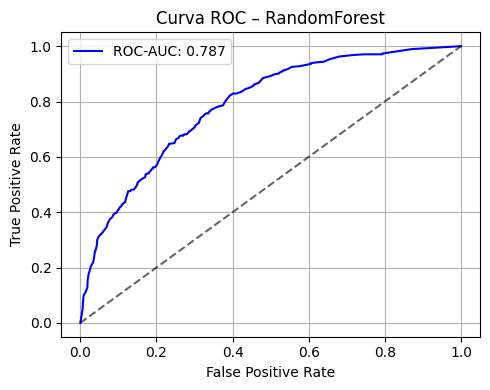

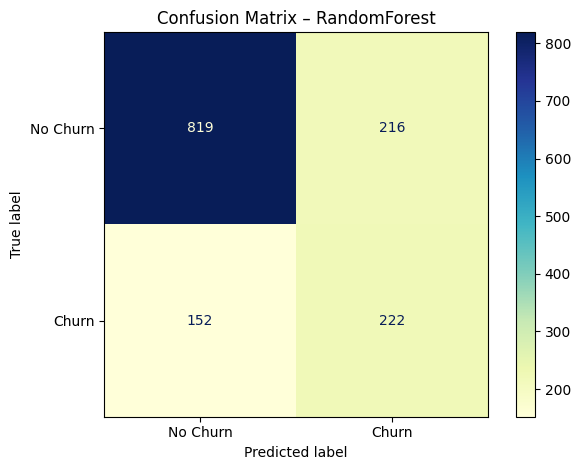


🔸Visualization for model: KNN


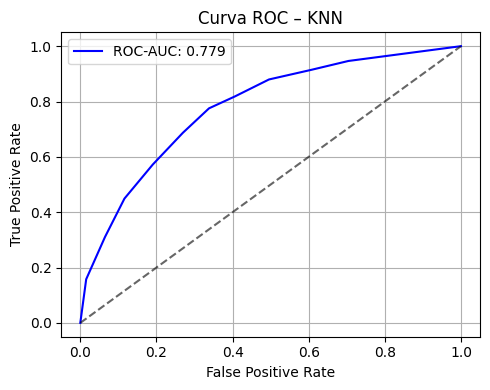

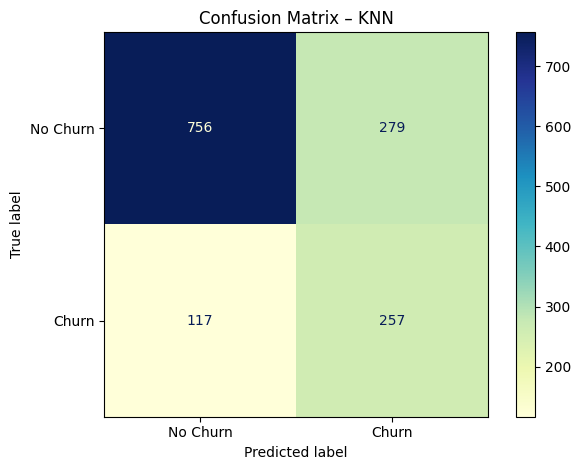

In [36]:
for name, pipeline in pipelines.items():
    print(f"\n🔸Visualization for model: {name}")
    
    y_proba = pipeline.predict_proba(X_test)[:,1]
    y_pred  = pipeline.predict(X_test)

    # --- Curva ROC ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}', color='blue')
    plt.plot([0,1], [0,1], 'k--', alpha=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC – {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Matriz de Confusión ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot(cmap='YlGnBu', values_format='d')
    plt.title(f'Confusion Matrix – {name}')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


### Comparación general de modelos para predicción de fuga de clientes

### Curva ROC y ROC-AUC
- Logistic Regression muestra el mejor desempeño en discriminación entre clientes que se van y los que se quedan, con un ROC-AUC de 0.811. Esto indica una buena capacidad para distinguir ambos grupos.

- Random Forest también ofrece un desempeño sólido (ROC-AUC de 0.787), aunque ligeramente inferior.

- KNN tiene un valor cercano (ROC-AUC de 0.779), pero no tan alto como Logistic Regression.

- Decision Tree, por otro lado, muestra un rendimiento más bajo (ROC-AUC de 0.671), lo cual indica que su capacidad de clasificación es más débil.

### Matrix Confusion
- Logistic Regression logra un equilibrio aceptable, identificando correctamente a 260 clientes que sí se dieron de baja, aunque clasifica erróneamente a 265 que no se fueron como si lo hubieran hecho.

- Random Forest acierta con 222 clientes que abandonaron, con menos falsos positivos (216) que Logistic.

- KNN detecta 257 clientes fugados, pero con un mayor número de falsos positivos (279).

- Decision Tree presenta el rendimiento más bajo, con 220 churns bien detectados y muchos errores tanto en falsos positivos (267) como falsos negativos (154).

### Conclusión práctica

El modelo Logistic Regression es el que ofrece el mejor equilibrio entre precisión, recall, F1-score y capacidad de discriminación (ROC-AUC), lo que lo convierte en la mejor opción para predecir la fuga de clientes en este escenario. Además, su simplicidad lo hace más fácil de interpretar y explicar frente a otras opciones más complejas.

Si se busca una alternativa con menor cantidad de falsos positivos, Random Forest también podría ser considerado, especialmente si se prioriza la precisión sobre el recall.

## 8. Feature Importance

In [37]:
rf_pipeline = pipelines['RandomForest']
rf_pipeline.fit(X_train, y_train)

rf_model = rf_pipeline.named_steps['classifier']

X_test_transformed = rf_pipeline.named_steps['preprocessor'].transform(X_test)

feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

result = permutation_importance(
    rf_model,
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

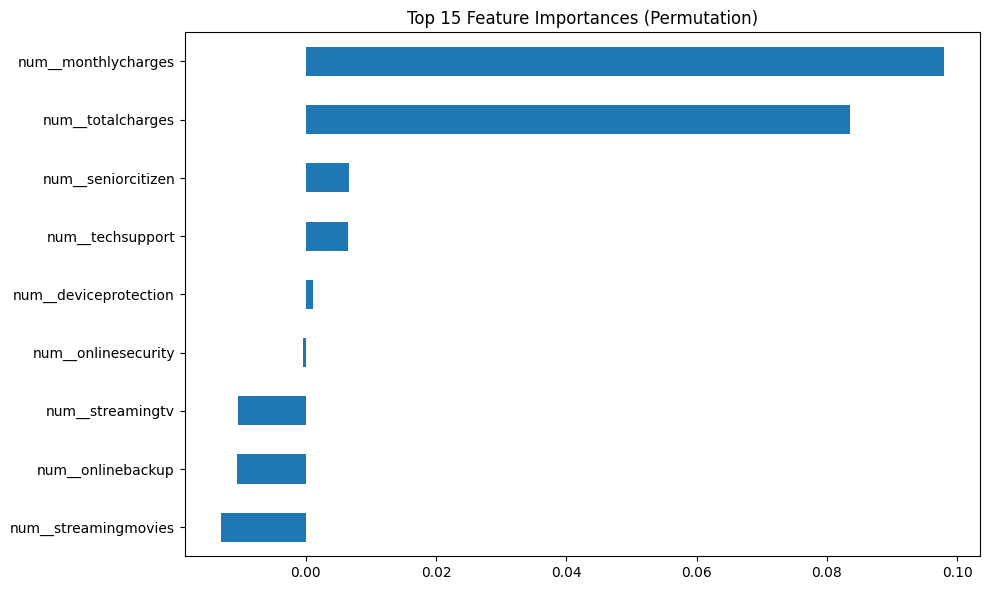

In [38]:
fi = pd.Series(result.importances_mean, index=feature_names)
fi.nlargest(15).sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Top 15 Feature Importances (Permutation)')
plt.tight_layout()
plt.show()

### Conclusiones sobre la importancia de las variables y la distribución de clases

Los cargos mensuales (monthlycharges) y los cargos totales (totalcharges) son, con diferencia, las variables que más influyen en la predicción de fuga de clientes. Esto sugiere que el comportamiento económico del cliente (cuánto paga y cuánto ha pagado en total) es un fuerte indicador de su permanencia o abandono del servicio.

La variable seniorcitizen (si el cliente es adulto mayor) también tiene cierta relevancia, aunque mucho menor. Esto podría reflejar diferencias en hábitos de consumo o necesidades específicas en este grupo poblacional.

Características relacionadas con servicios adicionales como tech support, device protection, online security, streaming, y online backup tienen una importancia marginal, aunque aportan algo de valor al modelo.

La distribución de clases en el conjunto de entrenamiento está desequilibrada:

73.46 % de los clientes no abandonaron el servicio.

Solo el 26.54 % sí se fue.

Esto indica un problema clásico de clase desbalanceada, donde es fundamental ajustar bien las métricas de evaluación (como F1-score y ROC-AUC) para no caer en modelos que predicen mayoritariamente la clase mayoritaria.

In [39]:
print("Distribución de clases en el entrenamiento:")
print(y_train.value_counts(normalize=True).map("{:.2%}".format))

Distribución de clases en el entrenamiento:
churn
0    73.46%
1    26.54%
Name: proportion, dtype: object


## 9. Pruebas de Hipótesis

Hipótesis estadística:

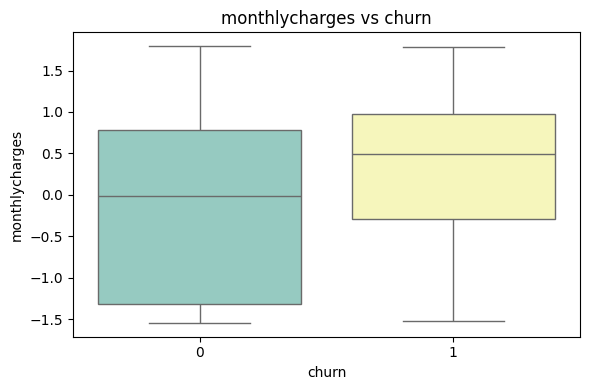

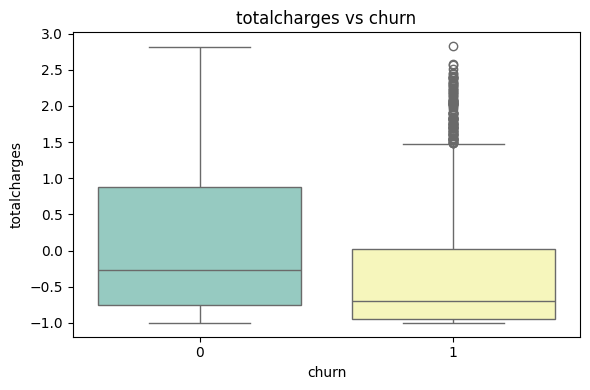

In [40]:
cols_interes = ['monthlycharges', 'totalcharges'] 

for col in cols_interes:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='churn', y=col, data=df_full, hue='churn', palette='Set3')
    plt.title(f'{col} vs churn')
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()

### Conclusiones sobre los boxplots de cargos y churn

Los clientes que abandonaron el servicio (churn = 1) tienden a tener cargos mensuales más altos en comparación con quienes se quedaron. Esto sugiere que un mayor valor mensual puede estar asociado a una menor percepción de valor o insatisfacción temprana.

Por otro lado, los clientes que se quedaron (churn = 0) tienen cargos totales acumulados mucho más altos, lo cual es lógico ya que llevan más tiempo en el servicio. En cambio, quienes se fueron acumularon menos pagos, lo que refuerza la idea de que muchos abandonan en los primeros meses.

Estos dos patrones indican que los clientes que pagan más mensualmente, pero que aún no han acumulado una gran inversión total, pueden sentirse menos comprometidos con la marca y por tanto más propensos a abandonar.

Esta tendencia apunta a una posible estrategia: ofrecer planes de entrada más asequibles o con beneficios percibidos más claros, para evitar que los nuevos clientes de alto costo se vayan antes de tiempo.

### Hipótesis 1

Plantea que el soporte técnico influye en el cargo mensual de quienes cancelan y eso puede ser causal de fuga.

H₀: No hay diferencia en la varianza de monthlycharges entre clientes con y sin techsupport.

H₁: Sí hay una diferencia en la varianza de monthlycharges entre clientes con y sin techsupport.

In [41]:
alpha = 0.05

df_cancelled = df_full[df_full['churn'] == 1]

with_support    = df_cancelled[df_cancelled['techsupport'] == 1]['monthlycharges']
without_support = df_cancelled[df_cancelled['techsupport'] == 0]['monthlycharges']

stat_levene, p_levene = levene(with_support, without_support)
equal_var = p_levene > alpha     # True → varianzas iguales

stat_t, p_ttest = ttest_ind(with_support, without_support, equal_var=equal_var)

print("📌 Prueba de Levene")
print(f"p-valor: {p_levene:.4f} → {'varianzas iguales' if equal_var else 'varianzas distintas'}")

print("\n📌 Prueba t de Student")
print(f"Estadístico t: {stat_t:.4f}")

if p_ttest <= alpha:
    print("✅ Existe una diferencia significativa en el promedio de cargos mensuales.")
else:
    print("❌ No hay diferencia significativa en el promedio.")

print(f"p-valor t-test: {p_ttest:.4f}")

📌 Prueba de Levene
p-valor: 0.0013 → varianzas distintas

📌 Prueba t de Student
Estadístico t: 5.5143
✅ Existe una diferencia significativa en el promedio de cargos mensuales.
p-valor t-test: 0.0000


In [42]:
print("With support:", with_support.mean())
print("Without support:", without_support.mean())

With support: 0.6479212849297145
Without support: 0.39222069988653385


### Hipótesis 1 - Conclusiones:
¿Influye el soporte técnico en el valor de los cargos mensuales de los clientes que se dan de baja?

La prueba de Levene indicó que las varianzas de los cargos mensuales entre clientes que cancelaron con y sin soporte técnico son diferentes (p-valor = 0.0013).

En promedio, los clientes que recibieron soporte técnico al cancelar presentaron cargos mensuales más altos (≈ 64.7%) que quienes no recibieron soporte (≈ 39.2%).

Interpretación:
Esto sugiere que los clientes que pagan más mensualmente podrían tener mayores expectativas de servicio, y si no obtienen un soporte técnico adecuado, podrían estar más propensos a abandonar. Además, el acceso al soporte técnico no parece haber frenado la decisión de cancelar, lo que puede evidenciar una falta de efectividad del soporte como herramienta de retención.

### Hipótesis 2

El tipo de contrato influye en el promedio de cancelación.

H₀: El tipo de contrato no influye en el promedio de los cargos mensuales entre los clientes que cancelaron su servicio.

H₁: El tipo de contrato sí influye en el promedio de los cargos mensuales entre los clientes que cancelaron.

In [43]:
alpha = 0.05

df_cancelled = df_full[df_full['churn'] == 1]

monthly   = df_cancelled[df_cancelled['type'] == 'Month-to-month']['monthlycharges']
longterm  = df_cancelled[df_cancelled['type'].isin(['One year', 'Two year'])]['monthlycharges']

stat_levene, p_levene = levene(monthly, longterm)
equal_var = p_levene > alpha   

stat_t, p_ttest = ttest_ind(monthly, longterm, equal_var=equal_var)

print("📌 Prueba de Levene")
print(f"p-valor Levene: {p_levene:.4f} → {'varianzas iguales' if equal_var else 'varianzas distintas'}")

print("\n📌 Prueba t de Student")
print(f"Estadístico t: {stat_t:.4f}")

if p_ttest <= alpha:
    print("✅ Existe una diferencia significativa en el promedio de cargos mensuales.")
else:
    print("❌ No hay diferencia significativa en el promedio.")

print(f"p-valor t-test: {p_ttest:.4f}")

📌 Prueba de Levene
p-valor Levene: 0.2349 → varianzas iguales

📌 Prueba t de Student
Estadístico t: -7.0197
✅ Existe una diferencia significativa en el promedio de cargos mensuales.
p-valor t-test: 0.0000


### Hipótesis 2 - Conclusiones:
¿Influye el tipo de contrato en el promedio de los cargos mensuales de los clientes que se dan de baja?

La prueba de Levene arrojó un p-valor de 0.2349, lo que indica que las varianzas entre los grupos son iguales (clientes con contrato mensual vs. contratos a uno o dos años).

La prueba t de Student, aplicada bajo el supuesto de varianzas iguales, mostró una diferencia estadísticamente significativa en el promedio de los cargos mensuales entre ambos grupos (p-valor < 0.0001, estadístico t = -7.02).

Interpretación:
Los resultados indican que el tipo de contrato sí influye en el monto de los cargos mensuales para los clientes que cancelaron. Específicamente, quienes tenían contratos mensuales pagaban un valor significativamente diferente (posiblemente más alto) que quienes estaban bajo contratos a largo plazo.

Esto sugiere que los clientes con compromisos contractuales más cortos pueden tener tarifas menos estables o más elevadas, y quizás una mayor flexibilidad para cancelar el servicio, lo que puede relacionarse directamente con su propensión a la fuga.

# ✅ Conclusiones Generales del Proyecto

Se cumplió exitosamente el objetivo del proyecto, al desarrollar un modelo predictivo de fuga de clientes para la empresa Interconnect, aplicando de manera integral un ciclo completo de un proyecto de ciencia de datos: desde la exploración hasta la interpretación de resultados.

El análisis permitió identificar variables clave en la decisión de cancelar el servicio, especialmente el monto de los cargos mensuales, los cargos totales acumulados, el tipo de contrato y el acceso a soporte técnico.

El modelo de Regresión Logística fue seleccionado como modelo final por su excelente balance entre rendimiento (ROC-AUC = 0.811), interpretabilidad y facilidad de implementación. Esto lo convierte en una herramienta efectiva tanto para predicción como para generación de estrategias de retención.

Durante el proceso de modelado se implementaron pipelines de preprocesamiento para asegurar un flujo ordenado, reproducible y escalable. Esto permitió integrar de forma estructurada pasos como la transformación de variables, normalización y entrenamiento del modelo, facilitando además la validación cruzada y comparación entre distintos algoritmos.

Las pruebas estadísticas realizadas confirmaron hipótesis importantes: los clientes con contratos más costosos o sin compromisos a largo plazo presentan mayor probabilidad de fuga, incluso cuando cuentan con servicios como soporte técnico.

El proyecto también demostró la importancia de comunicar hallazgos de forma clara y accesible, utilizando gráficos, visualizaciones y explicaciones sencillas para públicos no técnicos, cumpliendo así el segundo gran objetivo del proyecto.

Finalmente, se dejó una base sólida para avanzar hacia una implementación práctica, como campañas personalizadas de retención o integración del modelo en herramientas de atención al cliente.

 # 🧠 Plan de Trabajo – Interconnect: Anticipando la Fuga con Machine Learning

🎯 Objetivo del proyecto


Este proyecto busca aplicar los conocimientos adquiridos en ciencia de datos para desarrollar un modelo de Machine Learning capaz de predecir qué clientes de la empresa ficticia Interconnect tienen mayor probabilidad de cancelar su servicio. 

El objetivo no es solo construir un buen modelo, sino también entender el proceso completo: desde explorar los datos hasta comunicar los resultados de forma clara y útil.


1. Aterrizar el enfoque del proyecto


Con el objetivo ya definido, el primer paso será establecer bien el alcance del trabajo, decidir cómo vamos a medir el desempeño del modelo y organizar las etapas del proyecto para llevar un proceso ordenado y coherente.

2. Explorar y preparar los datos


Se analizarán los cuatro conjuntos de datos disponibles para conocer su contenido, detectar errores o valores faltantes y dejar todo listo para el modelado. La idea es construir una base consolidada que nos dé una visión completa de cada cliente.

3. Entrenar modelos y comparar resultados


Se probarán distintos algoritmos de clasificación (como regresión logística, Random Forest, entre otros), ajustando parámetros y evaluando qué tan bien predicen la cancelación de clientes. El foco estará en encontrar un modelo que sea preciso y útil para el análisis.

4. Evaluar e interpretar el modelo final


Más allá de los números, se buscará entender cómo funciona el modelo: qué variables tienen más peso, qué patrones detecta y qué tan confiables son sus predicciones.

5. Comunicar los hallazgos


Los resultados se presentarán de forma clara y visual, con gráficos e insights que expliquen no solo el qué, sino también el por qué. El objetivo es que cualquier persona que lea el informe pueda entender los hallazgos, incluso sin un perfil técnico.

6. Documentar y entregar el proyecto


Al final, se dejará todo el trabajo bien organizado: código limpio y comentado, un README con instrucciones claras, y un informe técnico que detalle cada paso del proceso. Todo quedará listo para ser evaluado como parte del cierre del bootcamp.